# Baltimore Parking Citation Data

## Final Project
Jonathan Hurwitz  
Amit Talapatra   
Wendy Zhang  
Wei Zheng

### Part 1: Selecting the dataset and importing packages

We selected a dataset of parking citations from the city of Baltimore for our assignment. We chose this dataset because it contained a good mix of different features that we believed would be interesting to explore. These features allowed us to explore the data from parameters of time, individual, nature of violation, and location. Other reasons we selected this dataset included that it contained a reasonable number of columns, and the data was of pretty good quality for the most part.

The types of questions we sought to answer included in increasing complexity included the following:  
1. What are the most common types of traffic violations?  
2. What are the characteristics of typical and repeat offenders?  
3. How does the volume of traffic violations change over time (e.g. hour, day, month)
4. How does the volume of traffic violations differ by location?  
  
After examining the data, we did identify a couple concerns. First, the data was pretty voluminous at over 800,000 records. To address this concern and improve performance in datanotebook, we limited the data for our analysis to just the year 2016. Second, there were a handful of null values in the data, including in the geolocation fields. To address this data gaps we populated placeholder values according to the datatype. Both of these actions will be called out again in the code that follows.


Before retrieving the dataset, we loaded a number of Python packages used in the visualizations we would ultimately produce.

In [1]:
!conda install shapely -y


Fetching package metadata .........
Solving package specifications: ..........

Package plan for installation in environment /opt/conda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geos-3.5.0                 |                0        16.9 MB
    shapely-1.5.16             |           py35_0         524 KB
    ------------------------------------------------------------
                                           Total:        17.4 MB

The following NEW packages will be INSTALLED:

    geos:    3.5.0-0      
    shapely: 1.5.16-py35_0

Fetching packages ...
geos-3.5.0-0.t 100% |################################| Time: 0:00:00  73.39 MB/s
shapely-1.5.16 100% |################################| Time: 0:00:00  20.36 MB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|######################

In [2]:
from shapely.geometry import shape, Point
import pandas as pd
import psycopg2 as pg
import numpy as np
import datetime
import json
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
pd.options.display.max_columns = 30

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


After loading our Python packages, we downloaded the data as a csv file, read into a dataframe, and performed some initial exploration.

In [3]:
!wget https://data.baltimorecity.gov/api/views/n4ma-fj3m/rows.csv?accessType=DOWNLOAD -O Parking_Citations.csv

--2016-12-08 20:58:28--  https://data.baltimorecity.gov/api/views/n4ma-fj3m/rows.csv?accessType=DOWNLOAD
Resolving data.baltimorecity.gov (data.baltimorecity.gov)... 52.206.68.26
Connecting to data.baltimorecity.gov (data.baltimorecity.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Parking_Citations.csv’

Parking_Citations.c     [        <=>           ] 143.30M  2.09MB/s   in 78s    

Last-modified header invalid -- time-stamp ignored.
2016-12-08 20:59:48 (1.83 MB/s) - ‘Parking_Citations.csv’ saved [150258655]



In [4]:
df = pd.read_csv('Parking_Citations.csv')

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.dtypes

Citation             int64
Tag                 object
ExpMM               object
ExpYY              float64
State               object
Make                object
Address             object
ViolCode           float64
Description         object
ViolFine            object
ViolDate            object
Balance             object
PenaltyDate        float64
OpenFine            object
OpenPenalty         object
NoticeDate          object
ImportDate          object
Neighborhood        object
PoliceDistrict      object
CouncilDistrict    float64
Location            object
dtype: object

### Part 2: Wrangling the data

As mentioned earlier, the data was generally in a pretty good format. However, we did take the following data cleansing steps to make the data more usable for our analyses:
* Splitting up latitude and longitude.
* Converting time to a 24-hour format.
* Replacing null values based on data type.

We also limited the dataset to 2016 records. We did not transform the data into a star schema format but instead retained its original structure which we believed to be sutiable for our analysis purposes. However, we did derive local variables for given parts of an analysis, which will be evident in the Part 3 code.

In [6]:
# create a 2016 subset
# Using I instead pf H to get 24 hour format
df.ViolDate = pd.to_datetime(df.ViolDate, format="%m/%d/%Y %I:%M:%S %p")
# split Location
df.set_index('ViolDate', inplace=True)
df = df['2016']
df.reset_index(inplace=True)
# convert to date type
df.ImportDate = df.ImportDate.str.replace(' \+0000', '')
df.NoticeDate = pd.to_datetime(df.NoticeDate, format="%m/%d/%Y")
df.PenaltyDate = pd.to_datetime(df.PenaltyDate, format="%m/%d/%Y")
df.ImportDate = pd.to_datetime(df.ImportDate, format="%m/%d/%Y %H:%M:%S %p")
# split Location
df['Latitude'] = df.Location.str.split(',').str.get(0).str.replace('\(','').map(lambda s: float(s))
df['Longitude'] = df.Location.str.split(',').str.get(1).str.replace('\)','').map(lambda s: float(s))
# remove $ sign
df[['ViolFine', 'Balance','OpenFine','OpenPenalty']] = df[['ViolFine', 'Balance','OpenFine','OpenPenalty']].applymap(lambda s: float(str(s).replace('$', '')))
# Clean EXP_MM 

mm_map = {val: val for val in df.ExpMM.unique()}
#  use 9999 to indictate not a number
#  use 888 to indiecate permanent 
#  leave 0 intact since we do not know what it means
mm_map[np.nan] = 9999
mm_map['PE'] = 888
df.ExpMM = df.ExpMM.map(mm_map)
df.ExpMM = df.ExpMM.astype(int)
df.ExpMM.unique()
df.ExpYY = df.ExpYY.astype(int)
df.Citation = df.Citation.astype(str)
df.ViolCode = df.ViolCode.astype(str)
df.CouncilDistrict = df.CouncilDistrict.astype(str)
#Replace null values based on datatype
rep_na = {
    "datetime64[ns]": datetime.datetime(9999,12,31),
    "object" :  "unknown",
    "float64" : np.nan,
    "int64" : np.nan,
}
for c, t in zip(df.columns, df.dtypes):
    df[c].fillna(rep_na[str(t)], inplace = True)
df.drop_duplicates(['Citation'], keep='last', inplace=True)
df.to_csv("clean_data.csv", index=False, header=True)


After cleansing the data, we loaded it into a postgres database.

In [7]:
%load_ext sql
!echo 'redspot' | sudo -S service postgresql restart
!createdb -U dbuser project3

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [8]:
%sql postgresql://dbuser@localhost:5432/project3

'Connected: dbuser@project3'

In [9]:
%%sql
DROP TABLE IF EXISTS citation;
CREATE TABLE citation (
    violdate TIMESTAMP,
    citation Varchar(9),
    tag Varchar(9),
    expmm Integer,
    expyy Integer,
    state Varchar(2),
    make Varchar(20),
    address Varchar(255),
    violcode Varchar(25),
    description Varchar(255),
    violfine Real,
    balance Real,
    penaltydate TIMESTAMP,
    openfine Real,
    openpenalty Real,
    noticedate TIMESTAMP,
    importdate TIMESTAMP,
    neighborhood Varchar(100),
    policedistrict Varchar(100),
    councildistrict Varchar(25),
    location Varchar(255),
    latitude Float8,
    longitude Float8,
    Primary Key(citation)
);

Done.
Done.


[]

Here we confirm that the volume of our dataset for the year 2016 was 326,740 records. Note that this dataset appears to be continuously updated so at the time this notebook is re-run the counts may be slightly different.

In [10]:
%%sql
COPY citation FROM '/home/jovyan/work/clean_data.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

326740 rows affected.


[]

In [11]:
%%sql
Select *
From citation
Limit 5;

5 rows affected.


violdate,citation,tag,expmm,expyy,state,make,address,violcode,description,violfine,balance,penaltydate,openfine,openpenalty,noticedate,importdate,neighborhood,policedistrict,councildistrict,location,latitude,longitude
2016-07-02 09:49:00,97036785,6ETF80,2,17,MD,LEXUS,400 ST PAUL PL,18.0,All Other Parking Meter Violations,32.0,0.0,9999-12-31 00:00:00,32.0,48.0,2016-07-20 00:00:00,2016-10-12 04:02:00,unknown,unknown,nan,unknown,None,None
2016-06-15 13:31:00,97059282,GLB4684,11,17,NY,KIA,800 BATTERY AVE,11.0,Residential Parking Permit Only,52.0,0.0,9999-12-31 00:00:00,52.0,0.0,9999-12-31 00:00:00,2016-10-18 04:01:00,unknown,unknown,nan,unknown,None,None
2016-09-29 12:14:00,97061411,59P149,9,18,MD,CHEVR,700 CALVERT ST,18.0,All Other Parking Meter Violations,32.0,0.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-10-01 04:02:00,unknown,unknown,nan,unknown,None,None
2016-03-11 14:26:00,96191623,9BP3607,10,16,MD,TOYOT,400 ST PAUL ST,18.0,All Other Parking Meter Violations,32.0,0.0,9999-12-31 00:00:00,0.0,0.0,9999-12-31 00:00:00,2016-03-31 04:02:00,unknown,unknown,nan,unknown,None,None
2016-03-11 14:39:00,96191631,20971CG,10,17,MD,FORD,100 ST PAUL ST,8.0,No Stopping/Standing Tow Away Zone,52.0,0.0,9999-12-31 00:00:00,0.0,0.0,9999-12-31 00:00:00,2016-04-08 04:02:00,unknown,unknown,nan,unknown,None,None


### Part 3: Analysis

#### Analysis 1: Citation D3 Geospatial Dashboard
The steps to create this geospatial dashboard included the following:
    1. Filter data  to obtain citations with location information.
    2. Calculate summary statistics
    3. Join citation data with Baltimore geojson files.
    4. Create a d3 interactive dashboard
This dashboard allows a user to click on different regions in the Baltimore area and observe traffic citation data, while also manipulating various measures. Note that this D3 dashboard uses packages which may not load properly in the Jupyter notebook. If this is the case, please refer to the github files in Wei's repository that is referenced below.

In [12]:
df_has_loc = df[df.Location != 'unknown']
df_has_loc.shape

(56245, 23)

In [13]:
#Download baltimore neighborhoods and street gesjosn files
#source: https://data.baltimorecity.gov/widgets/tau7-6emy
#reduced-size file  
!wget https://raw.githubusercontent.com/zhengweifz/istm-6212/master/Street_Centerlines.geojson -O Street_Centerlines.geojson
!wget http://feyderm.github.io/data/Baltimore_vacant_buildings_Shape.geojson -O baltimore.geojson
with open('baltimore.geojson', 'r') as f:
    geo = json.load(f)
### Check Neighborhood granularity so that we can join coordinates with shapes in the geojson file  
print('Number of Neighborhoods in Geojson: {0}'.format(len(geo['features'])))
print('Number of Neighborhoods in Dataset: {0}'.format(len(df.Neighborhood.unique())))    

--2016-12-08 21:00:55--  https://raw.githubusercontent.com/zhengweifz/istm-6212/master/Street_Centerlines.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15159444 (14M) [text/plain]
Saving to: ‘Street_Centerlines.geojson’

Street_Centerlines. 100%[=====================>]  14.46M  81.7MB/s   in 0.2s   

2016-12-08 21:00:56 (81.7 MB/s) - ‘Street_Centerlines.geojson’ saved [15159444/15159444]

--2016-12-08 21:00:56--  http://feyderm.github.io/data/Baltimore_vacant_buildings_Shape.geojson
Resolving feyderm.github.io (feyderm.github.io)... 151.101.32.133
Connecting to feyderm.github.io (feyderm.github.io)|151.101.32.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1708983 (1.6M) [application/json]
Saving to: ‘baltimore.geojson’

baltimore.geojson   100%[==============

##### There is a difference in granularity.

In [14]:
#free memory
del df

In [15]:
geo_nhs = np.array([f['properties']['csa'] for f in geo['features'] ])
df_nhs = [g for g in df_has_loc.Neighborhood.unique() if str(g) != 'nan']
# create a mapping for neighborhood names 
nhs_map = [geo_nhs[i] if i != -1 else 'unknown' for  i in 
             [max([i if g in s else -1 for i, s in enumerate(geo_nhs)]) for g in df_nhs]]
nhs_map_dict = {d: g for d, g in zip(df_nhs, nhs_map)}
df_has_loc['Geo_Neighborhood'] = df_has_loc.Neighborhood.map(nhs_map_dict)
#Now we use coordinates to determine neighborhoods for the unkowns
df_NH_Known = df_has_loc[df_has_loc.Geo_Neighborhood != 'unknown']
df_NH_Unknown = df_has_loc[df_has_loc.Geo_Neighborhood == 'unknown']
del df_has_loc
areas = [shape(f['geometry']) for f in geo['features']]
def inShape(row):
    long = row['Longitude']
    lat = row['Latitude']
    point = Point(long, lat)
    index = -1 
    for i, s in enumerate(areas):
        if s.contains(point):
            index = i
            return index
    return index
geo_nhs_index = df_NH_Unknown.apply(inShape, axis=1)
#Join data points with Geo Neighborhoods
df_NH_Unknown.Geo_Neighborhood = geo_nhs[geo_nhs_index] 
df_has_loc = df_NH_Known.append(df_NH_Unknown, ignore_index=True)
del df_NH_Known
del df_NH_Unknown
df_has_loc.shape


(56245, 24)

In [16]:
#calculate additional features
df_has_loc['ViolDateTime'] = df_has_loc['ViolDate']
df_has_loc['ViolDate'] = df_has_loc['ViolDateTime'].dt.date
df_has_loc['ViolMonth'] = df_has_loc['ViolDateTime'].dt.month
df_has_loc['ViolWeekday'] = df_has_loc['ViolDateTime'].dt.weekday_name
###Create summaries for each geo neighborhood, which will be used for visualizations
count_by_geo_nhs = df_has_loc.groupby('Geo_Neighborhood')['Citation'].count().to_dict()
fine_by_geo_nhs = df_has_loc.groupby('Geo_Neighborhood')['ViolFine'].sum().to_dict()
def count2dict(df, col):
    key = [str(k) for k in df[col].unique()]
    key.insert(0,'All')
    gr = df.groupby(['Geo_Neighborhood', col])['Citation'].count()
    index = gr.index.levels[0]
    return (key, {c: [{col: str(i),'value': int(v)} for i,v in  gr[c].to_dict().items()] for c in index})
month_keys, count_by_geo_month_nhs = count2dict(df_has_loc, 'ViolMonth')
weekday_keys, count_by_geo_Weekday_nhs = count2dict(df_has_loc, 'ViolWeekday')
state_keys, count_by_geo_state_nhs = count2dict(df_has_loc, 'State')
geo['month_keys'] = month_keys
geo['weekday_keys'] = weekday_keys
geo['state_keys'] = state_keys
#Store citation data points in each geo neighborhood
data_points = {};
for n, d in df_has_loc.astype(str).groupby(df_has_loc.Geo_Neighborhood):
    data_points[n] = d.to_dict(orient='record')
del df_has_loc
for i, f in enumerate(geo['features']):
    if geo['features'][i]['properties']['csa'] != 'Unassigned -- Jail':
        # have to covert numpy int dtype to python int type for json serialization 
        geo['features'][i]['properties']['citation_count'] = int(count_by_geo_nhs[geo['features'][i]['properties']['csa']])
        geo['features'][i]['properties']['total_fine'] = float(fine_by_geo_nhs[geo['features'][i]['properties']['csa']])
        geo['features'][i]['properties']['month_count'] = count_by_geo_month_nhs[geo['features'][i]['properties']['csa']]
        geo['features'][i]['properties']['weekday_count'] = count_by_geo_Weekday_nhs[geo['features'][i]['properties']['csa']]
        geo['features'][i]['properties']['state_count'] = count_by_geo_state_nhs[geo['features'][i]['properties']['csa']]
        geo['features'][i]['properties']['data_points'] = data_points[geo['features'][i]['properties']['csa']]
        #free memory
        del data_points[geo['features'][i]['properties']['csa']]
with open('citation.geojson', 'w') as f:
    json.dump(geo, f)
del geo

##### D3 dashboard http://zhengweifz.github.io
Use github.io for better presentation.
The working ipython version of dashboard is in the last two cells of this notebook. 


#### Explore the top 10 violations that result in the most amount of total fine and corresponding total open fine.

In [17]:
%%sql
select violcode, description, count(violcode), sum(violfine) as Total_Viol_Fine, sum(openfine) as Total_Open_Fine
from citation
group by violcode, description
order by Total_Viol_Fine desc limit 10;

10 rows affected.


violcode,description,count,total_viol_fine,total_open_fine
18.0,All Other Parking Meter Violations,112013,3584420.0,1412740.0
27.0,No Stop/Park Street Cleaning,43009,2236470.0,1053230.0
8.0,No Stopping/Standing Tow Away Zone,34776,1808300.0,722791.0
11.0,Residential Parking Permit Only,24493,1273640.0,499244.0
12.0,No Stopping/Standing Not Tow-Away Zone,35594,1138950.0,441650.0
26.0,No Stop/Park Handicap,2109,1057510.0,566831.0
22.0,Expired Tags,31206,998577.0,576144.0
1.0,Abandonded Vehicle,1927,581954.0,456501.0
16.0,In Transit Zone/Stop,5948,457996.0,204176.0
5.0,Obstruct/Impeding Movement of Pedestrian,5573,429121.0,175339.0


#### Analysis 2: Violation Characteristics

First we explored, the top 10 individual violations that result in the most amount of fine. 

In [18]:
%%sql
select distinct violcode, description, violfine
from citation
order by violfine desc limit 10;

10 rows affected.


violcode,description,violfine
9.0,"Commercial Veh/Residence over 20,000 lbs",502.0
26.0,No Stop/Park Handicap,502.0
1.0,Abandonded Vehicle,302.0
9.0,"Commercial Veh/Residence over 20,000 lbs",302.0
10.0,"Commercial Veh/Residence under 20,000 lbs",252.0
26.0,No Stop/Park Handicap,200.0
15.0,No Stopping//Parking Stadium Event Camden,102.0
2.0,No Stopping or No Parking Pimlico Event,102.0
3.0,Obstruct/Impeding Flow of Traffic,102.0
16.0,In Transit Zone/Stop,77.0


Next we explored the top 10 states that have the most number of violations

In [19]:
%%sql
select state, count(violcode) as Total_Violations
from citation
group by state
order by Total_Violations desc limit 10;

10 rows affected.


state,total_violations
MD,274498
VA,8829
PA,8723
NJ,3735
NY,3529
FL,2512
TN,2414
NC,2212
DC,2165
DE,1852


<Container object of 10 artists>

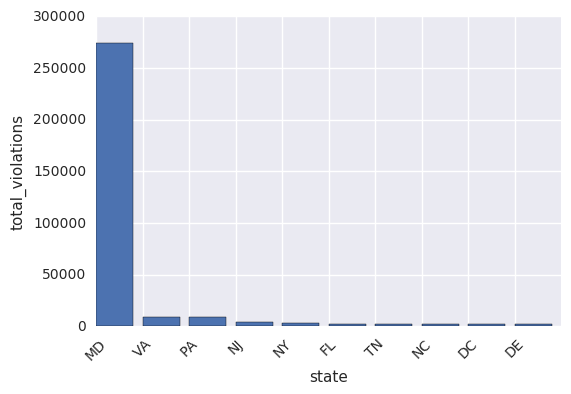

In [20]:
result = _
result.bar()

The state of Maryland seems to have the most number of violations by orders of magnitude. Its total is over 250,000 records while the other states are less than 10,000. The next step is subsetting the data for Maryland specifically to provide further details to reveal the nature of the violations.

In [21]:
%%sql
select description, sum(violfine) as Total_Viol_Fine
from citation
where state = 'MD'
group by description
order by Total_Viol_Fine desc limit 10
;

10 rows affected.


description,total_viol_fine
All Other Parking Meter Violations,3050880.0
No Stop/Park Street Cleaning,1942980.0
No Stopping/Standing Tow Away Zone,1515240.0
Residential Parking Permit Only,1011970.0
No Stopping/Standing Not Tow-Away Zone,953673.0
No Stop/Park Handicap,928496.0
Expired Tags,867569.0
Abandonded Vehicle,487126.0
In Transit Zone/Stop,377685.0
Obstruct/Impeding Movement of Pedestrian,365442.0


In [22]:
%%sql
create table MD as 
select description, sum(violfine) as Total_Viol_Fine
from citation
where state = 'MD'
group by description
order by Total_Viol_Fine desc limit 10
;

10 rows affected.


[]

In [23]:
%%sql
drop table if exists other_states;
    create table other_states as 
    select state, description, sum(violfine) as Total_Viol_Fine
    from citation
    where state != 'MD'
    group by state, description
    order by Total_Viol_Fine desc limit 10
;

Done.
10 rows affected.


[]

In [24]:
%%sql
select *
from other_states;

10 rows affected.


state,description,total_viol_fine
VA,All Other Parking Meter Violations,107104.0
PA,All Other Parking Meter Violations,91072.0
PA,No Stop/Park Street Cleaning,50232.0
VA,No Stop/Park Street Cleaning,49868.0
VA,No Stopping/Standing Tow Away Zone,48932.0
PA,No Stopping/Standing Tow Away Zone,46332.0
PA,Residential Parking Permit Only,44200.0
NJ,All Other Parking Meter Violations,42208.0
TN,All Other Stopping or Parking Violations,41024.0
VA,Residential Parking Permit Only,39208.0


The result of the query below shows that Maryland and other states share quite a few common violations because the total of top 10 violations from both tables turn out to be 11. 

In [25]:
%%sql
select description from MD
union 
select description from other_states;

11 rows affected.


description
All Other Parking Meter Violations
No Stop/Park Handicap
No Stopping/Standing Not Tow-Away Zone
Expired Tags
Residential Parking Permit Only
In Transit Zone/Stop
No Stop/Park Street Cleaning
Obstruct/Impeding Movement of Pedestrian
All Other Stopping or Parking Violations
No Stopping/Standing Tow Away Zone


To see the different violations that do not occur in one or the other, the following list provdies details.

In [26]:
%%sql
SELECT  description from MD
except 
select description from other_states
;

6 rows affected.


description
Obstruct/Impeding Movement of Pedestrian
No Stop/Park Handicap
No Stopping/Standing Not Tow-Away Zone
Expired Tags
Abandonded Vehicle
In Transit Zone/Stop


Based on total fine amount the violations that bring in the most amount of revenue.

#### Analysis 3: Investigating citation data by the individual characteristics

First, we examined which cars were the most ticketed.

In [27]:
%%sql
select make, count(citation)
from citation
group by make
order by count(citation) desc
limit 20;

20 rows affected.


make,count
HONDA,39530
TOYOT,38627
FORD,34605
CHEVR,25996
NISSA,25654
HYUND,14389
DODGE,12110
JEEP,10512
VOLKS,10128
ACURA,9525


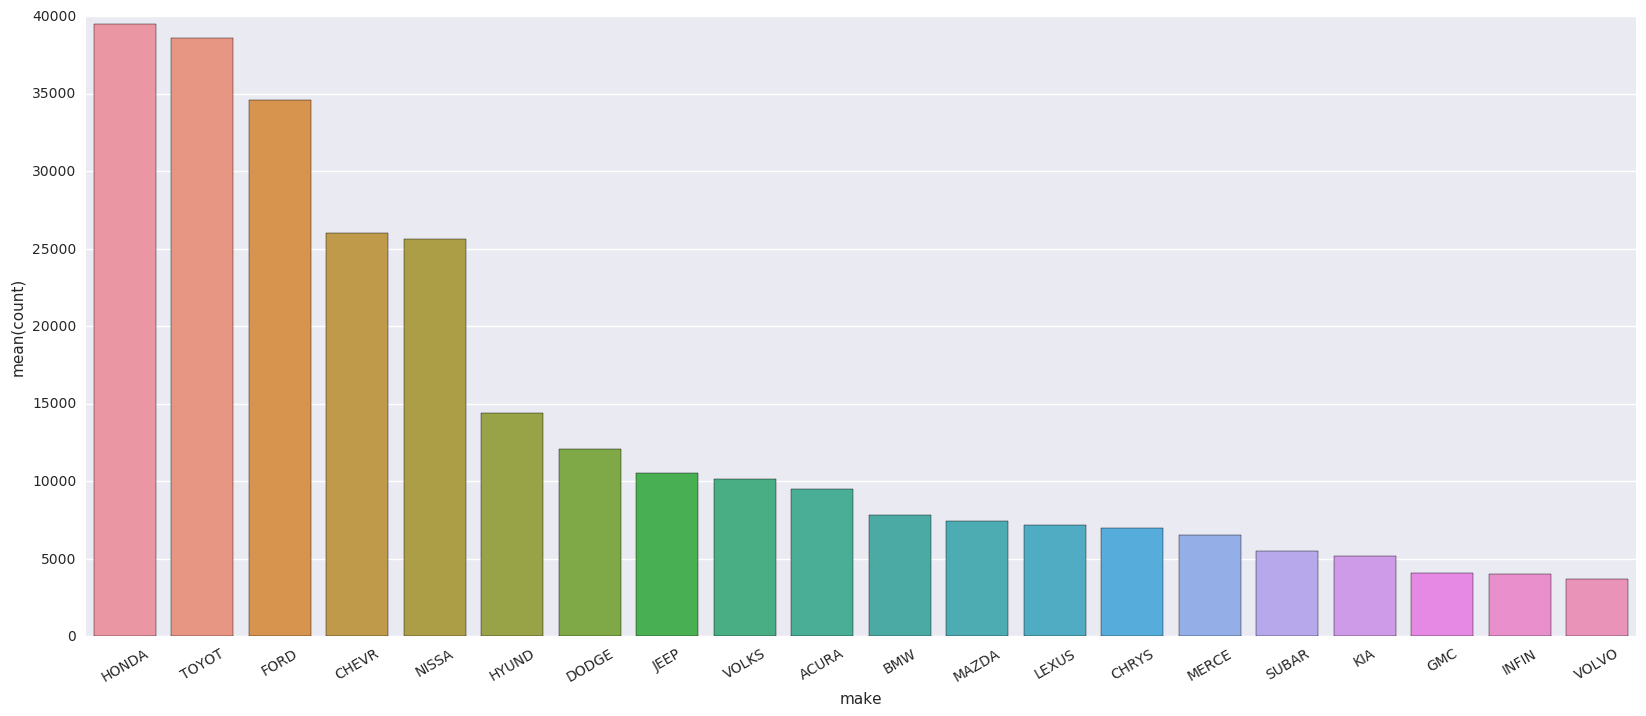

In [28]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='make', y='count', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=30)
del d

This plot is not particularly useful to us. As expected, more common vehicles will have more violations in the database. If we used data on vehicles licensed in the state, by vehicle make, we could see if a particular make of vehicle results in a disproportionate amount of violations.

Next we sought to find the drivers with the most violations. We believed it would be interesting to use this data to find repeat offenders using their license plate tags

In [30]:
%%sql
select tag, make, state, count(citation)
from citation
group by tag, make, state
order by count(citation) desc
limit 20;

20 rows affected.


tag,make,state,count
9BL2577,VOLKS,MD,66
LVF001,TOYOT,MD,63
5BF6174,LEXUS,MD,60
8767631,TOYOT,IL,59
A065284,GMC,MD,59
3DGREES,TOYOT,MD,58
2CF4276,HYUND,MD,54
ABF80Y,JEEP,MD,53
6ZFS977,KIA,CA,51
4CF9473,JAGUA,MD,51


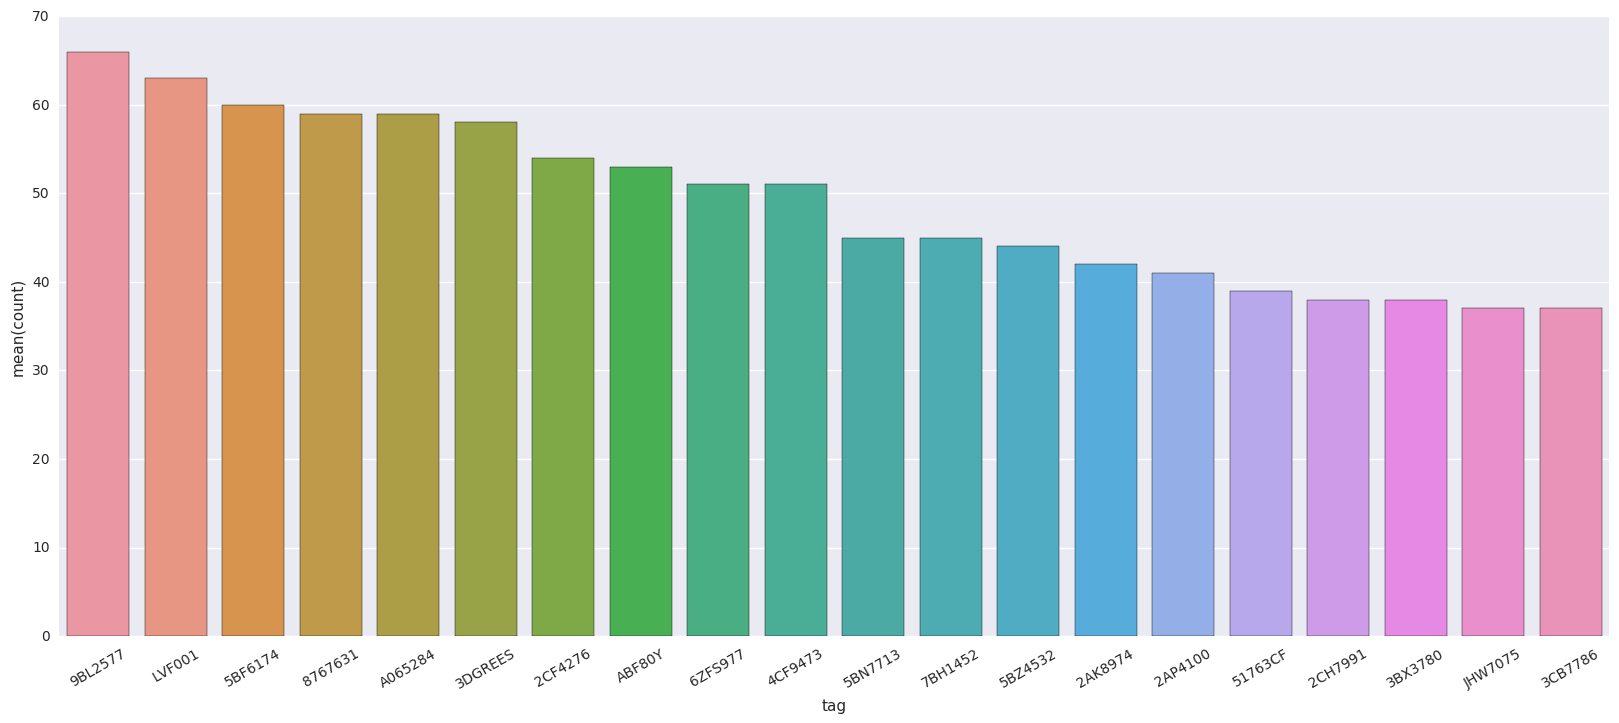

In [31]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='tag', y='count', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=30)
del d

The chart above can be used to identify the top offenders, and we can refer to the results of the previous SQL query to identify the vehicle make and state that its plates are registered in.

Next, we produced a heatmap to identify top offenders by violation type. 

In [32]:
%%sql
select tag, description, count(citation)
from citation
group by tag, description
order by count(citation) desc
limit 100;

100 rows affected.


tag,description,count
NOTAGS T,All Other Stopping or Parking Violations,142
3DGREES,All Other Parking Meter Violations,57
8767631,All Other Parking Meter Violations,49
6ZFS977,All Other Parking Meter Violations,48
A065284,All Other Parking Meter Violations,44
5BN7713,All Other Parking Meter Violations,44
5BF6174,No Stopping/Standing Not Tow-Away Zone,41
7BH1452,All Other Parking Meter Violations,39
9BL2577,Expired Tags,36
3CB7786,All Other Parking Meter Violations,35


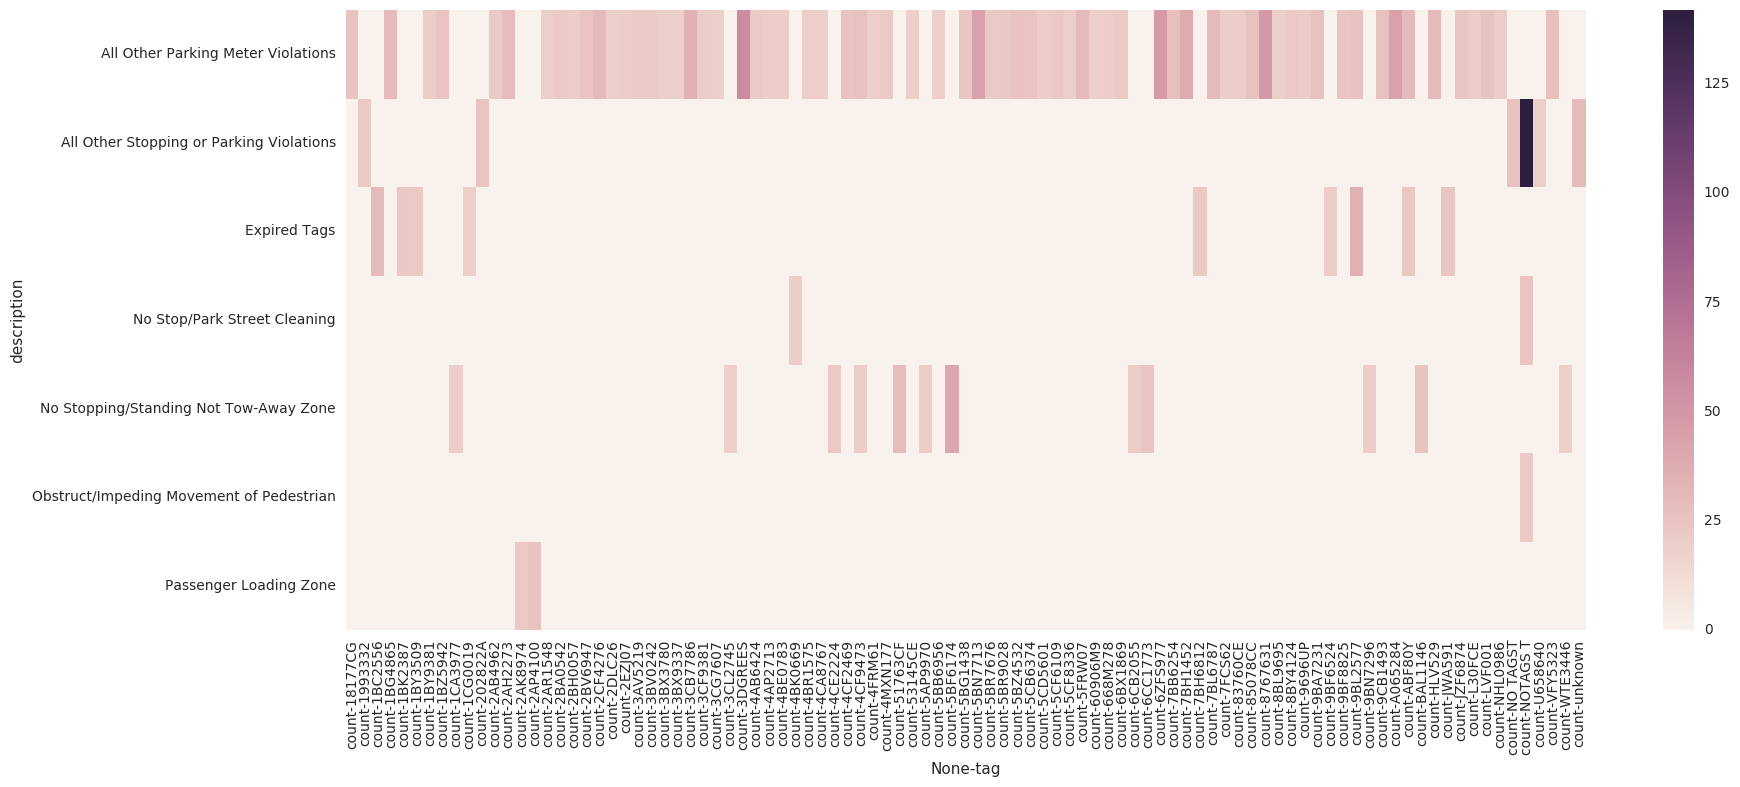

In [33]:
d = _.DataFrame()
d = d.groupby(['description', 'tag']).sum().unstack('tag')
d = d.fillna(0)
d
rc('figure', figsize=(20, 8))
splt = sns.heatmap(data=d)
del d
#splt.set_xticklabels(labels, rotation=90)

#### A heatmap to identify top offenses connected to out-of-state license plates.
We would like to see what other states the top offenders have their tags registered in. To view this as a heatmap, we first make a SQL query that ignores violations where the state is listed as Maryland.

In [34]:
%%sql
select description, state, count(citation)
from citation
where state != 'MD'
group by description, state
order by count(citation) desc
limit 100;

100 rows affected.


description,state,count
All Other Parking Meter Violations,VA,3347
All Other Parking Meter Violations,PA,2846
All Other Parking Meter Violations,NJ,1319
All Other Stopping or Parking Violations,TN,1282
All Other Parking Meter Violations,NY,1214
All Other Parking Meter Violations,DC,1063
No Stopping/Standing Not Tow-Away Zone,PA,1030
No Stop/Park Street Cleaning,PA,966
No Stop/Park Street Cleaning,VA,959
No Stopping/Standing Tow Away Zone,VA,941


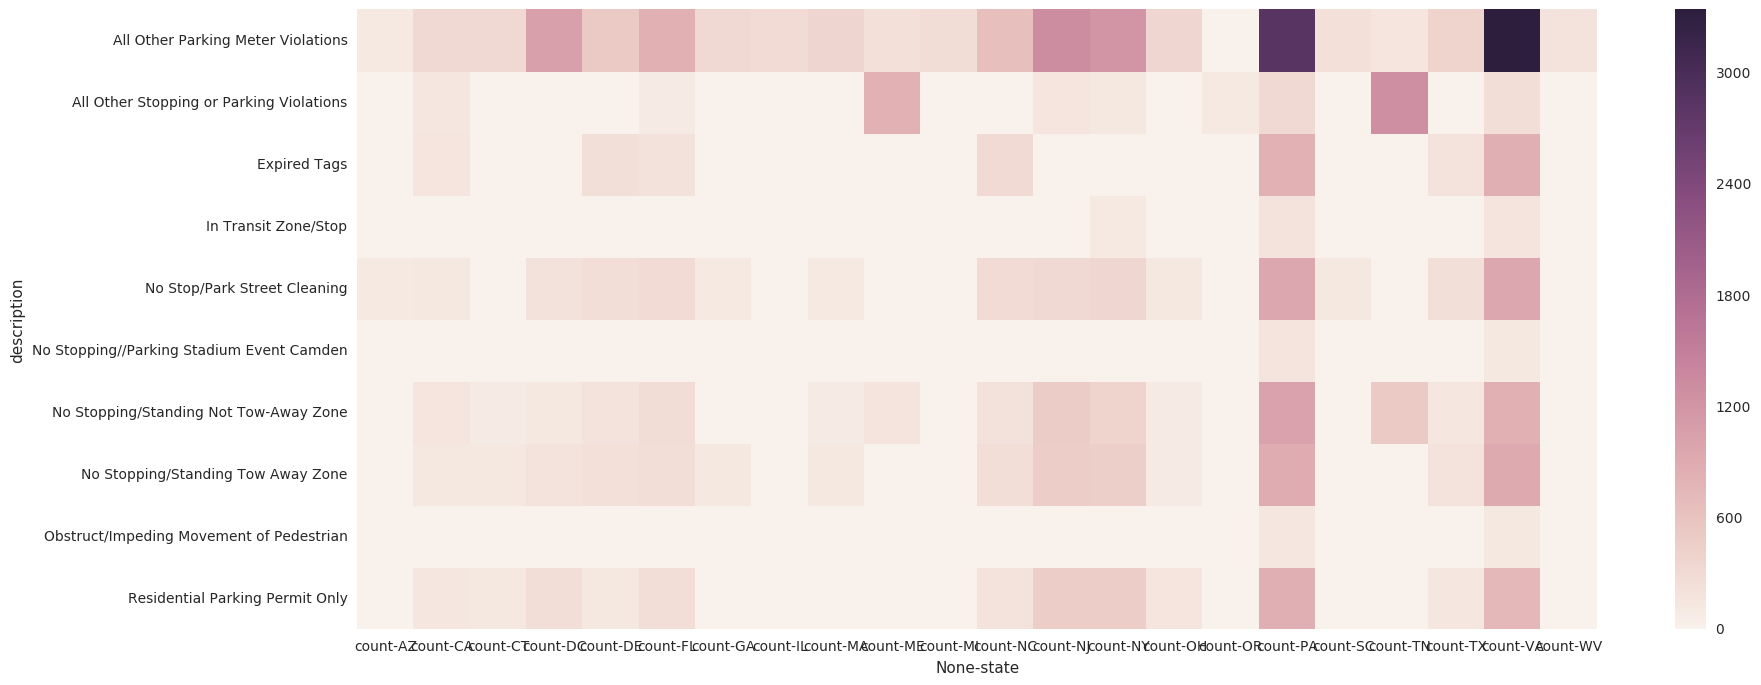

In [35]:
d = _.DataFrame()
d = d.groupby(['description', 'state']).sum().unstack('state')
d = d.fillna(0)
#rc('figure', figsize=(20, 8))
splt = sns.heatmap(data=d)
del d

As expected, most of the non-Maryland offenders come from neighboring states, but there are some that still have a significant number of offenses and come from states that are further away. This could be used to identify vehicle owners that are keeping out-of-state plates for an extended period.

#### Analysis 4: Looking at traffic citation data from a time perspective

First, we examined citation volume by each hour of the day.

In [36]:
%%sql
Select date_part('hour', violdate) as hour
    ,count(*) as citation_volume
From citation
Group By date_part('hour', violdate)
Order By date_part('hour', violdate);

24 rows affected.


hour,citation_volume
0.0,1402
1.0,1238
2.0,602
3.0,547
4.0,520
5.0,490
6.0,689
7.0,13645
8.0,26411
9.0,26294


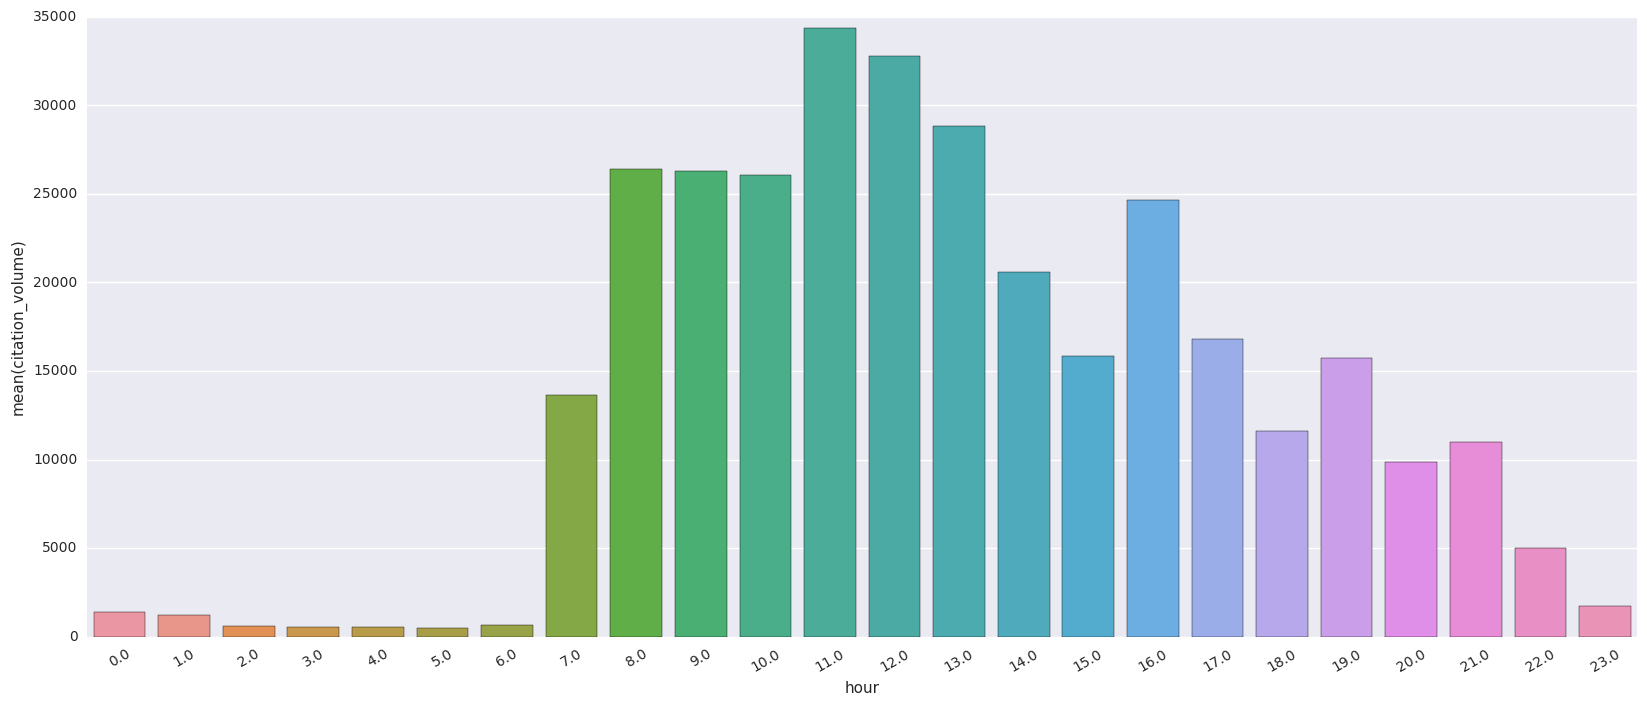

In [37]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='hour', y='citation_volume', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=30)
del d

This analysis shows that the majority of parking citations are issued during the work day hours, with a peak during mid day between 11 am and 1 pm.

Next, we analyzed parking citation volume by day of the week for the year 2016.

In [38]:
%%sql
Select Case When extract(dow from violdate)= 0 Then 'Sun'
        When extract(dow from violdate)= 1 Then 'Mon'
        When extract(dow from violdate)= 2 Then 'Tue'
        When extract(dow from violdate)= 3 Then 'Wed'
        When extract(dow from violdate)= 4 Then 'Thu'
        When extract(dow from violdate)= 5 Then 'Fri'
        When extract(dow from violdate)= 6 Then 'Sat' End As dow
    ,count(*) as citation_volume
From citation
Group By extract(dow from violdate)
Order By extract(dow from violdate);

7 rows affected.


dow,citation_volume
Sun,20781
Mon,52475
Tue,56506
Wed,57083
Thu,55762
Fri,52962
Sat,31171


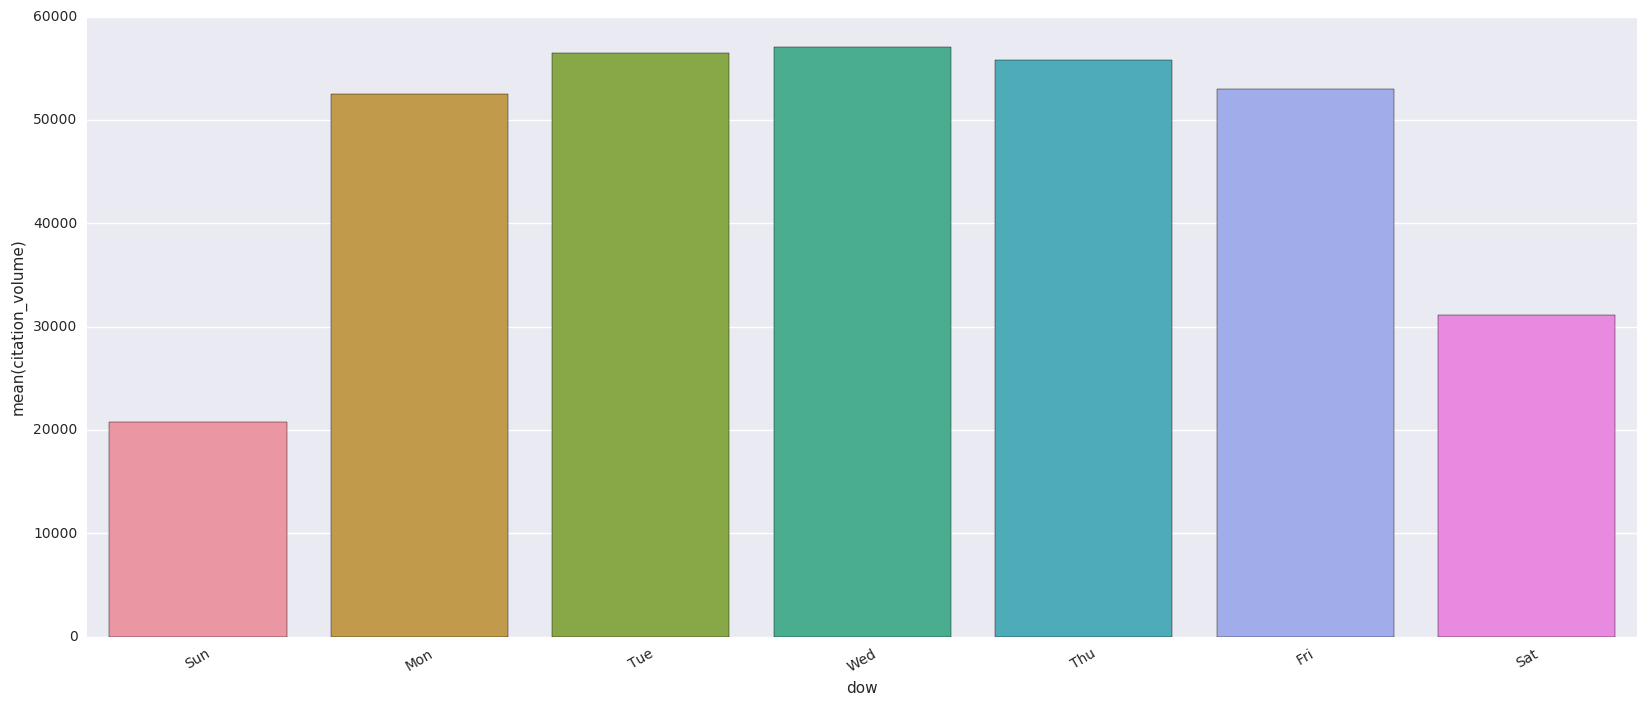

In [39]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='dow', y='citation_volume', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=30)
del d

This graph shows that the majority of parking citations occur during the weekdays, which makes sense as there is likely more downtown traffic during business hours.

The below heatmap combines day and hour data to assess whether certain days exhibit different time patterns.

In [40]:
%%sql
Select Case When extract(dow from violdate)= 0 Then 'Sun'
        When extract(dow from violdate)= 1 Then 'Mon'
        When extract(dow from violdate)= 2 Then 'Tue'
        When extract(dow from violdate)= 3 Then 'Wed'
        When extract(dow from violdate)= 4 Then 'Thu'
        When extract(dow from violdate)= 5 Then 'Fri'
        When extract(dow from violdate)= 6 Then 'Sat' End As dow
    ,date_part('hour', violdate) as hour 
    ,count(*) as citation_volume
From citation
Group By extract(dow from violdate)
    ,date_part('hour', violdate)
Order By extract(dow from violdate);

168 rows affected.


dow,hour,citation_volume
Sun,0.0,609
Sun,1.0,188
Sun,2.0,29
Sun,3.0,26
Sun,4.0,17
Sun,5.0,18
Sun,6.0,28
Sun,7.0,66
Sun,8.0,169
Sun,9.0,679


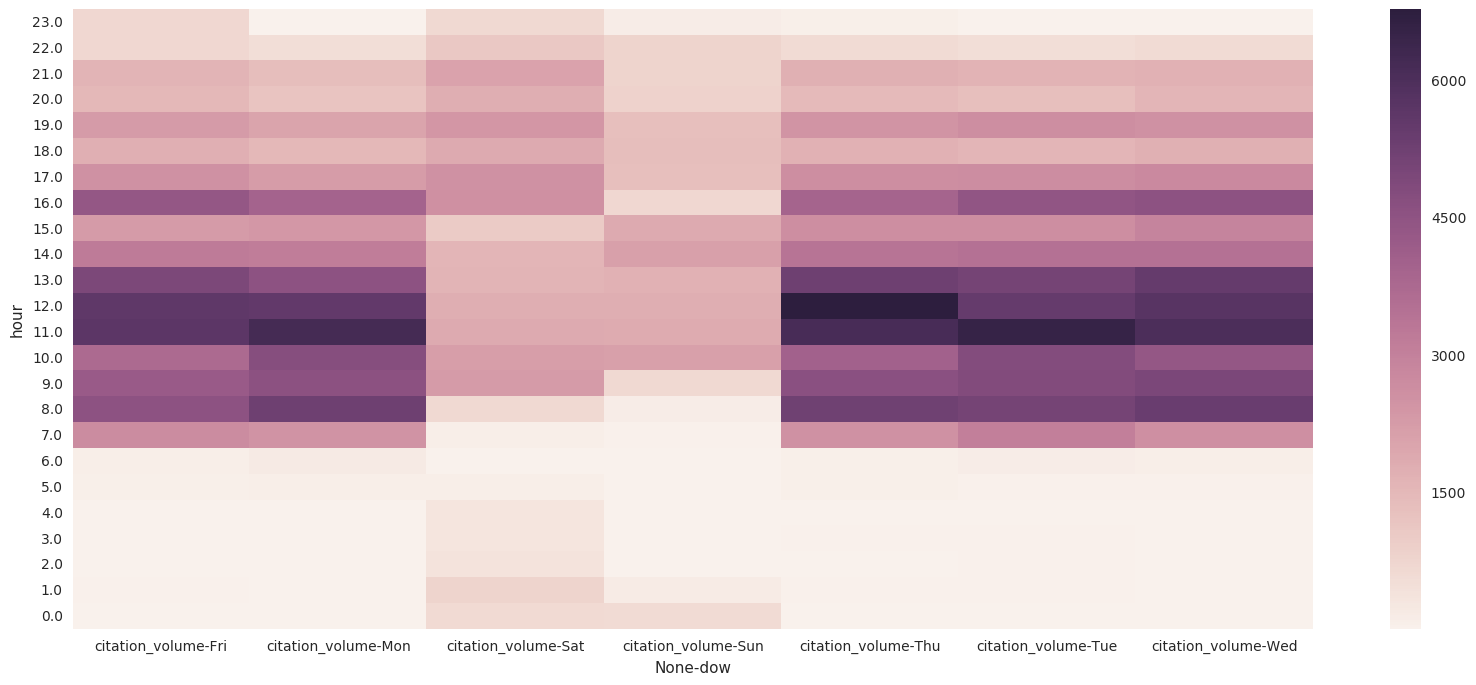

In [41]:
d = _.DataFrame()
d = d.groupby(['dow', 'hour']).sum().unstack('dow')
d = d.fillna(0)
#rc('figure', figsize=(20, 8))
splt = sns.heatmap(data=d)
splt.invert_yaxis()
del d

This analysis shows that while the mid day hours are typically the worst time for getting a parking ticket, Thursday at noon stands out as especially unlucky!

Finally, we examined parking citation volume by month for the year 2016.

In [42]:
%%sql
Select Case When date_part('month', violdate)= 1 Then 'Jan'
        When date_part('month', violdate)= 2 Then 'Feb'
        When date_part('month', violdate)= 3 Then 'Mar'
        When date_part('month', violdate)= 4 Then 'Apr'
        When date_part('month', violdate)= 5 Then 'May'
        When date_part('month', violdate)= 6 Then 'Jun'
        When date_part('month', violdate)= 7 Then 'Jul'
        When date_part('month', violdate)= 8 Then 'Aug'
        When date_part('month', violdate)= 9 Then 'Sep'
        When date_part('month', violdate)= 10 Then 'Oct'
        When date_part('month', violdate)= 11 Then 'Nov'
        When date_part('month', violdate)= 12 Then 'Dec' End As month
    ,count(*) as citation_volume
From citation
Group By date_part('month', violdate)
Order By date_part('month', violdate);

12 rows affected.


month,citation_volume
Jan,22224
Feb,27552
Mar,33418
Apr,31337
May,32080
Jun,29714
Jul,26454
Aug,30303
Sep,27938
Oct,30943


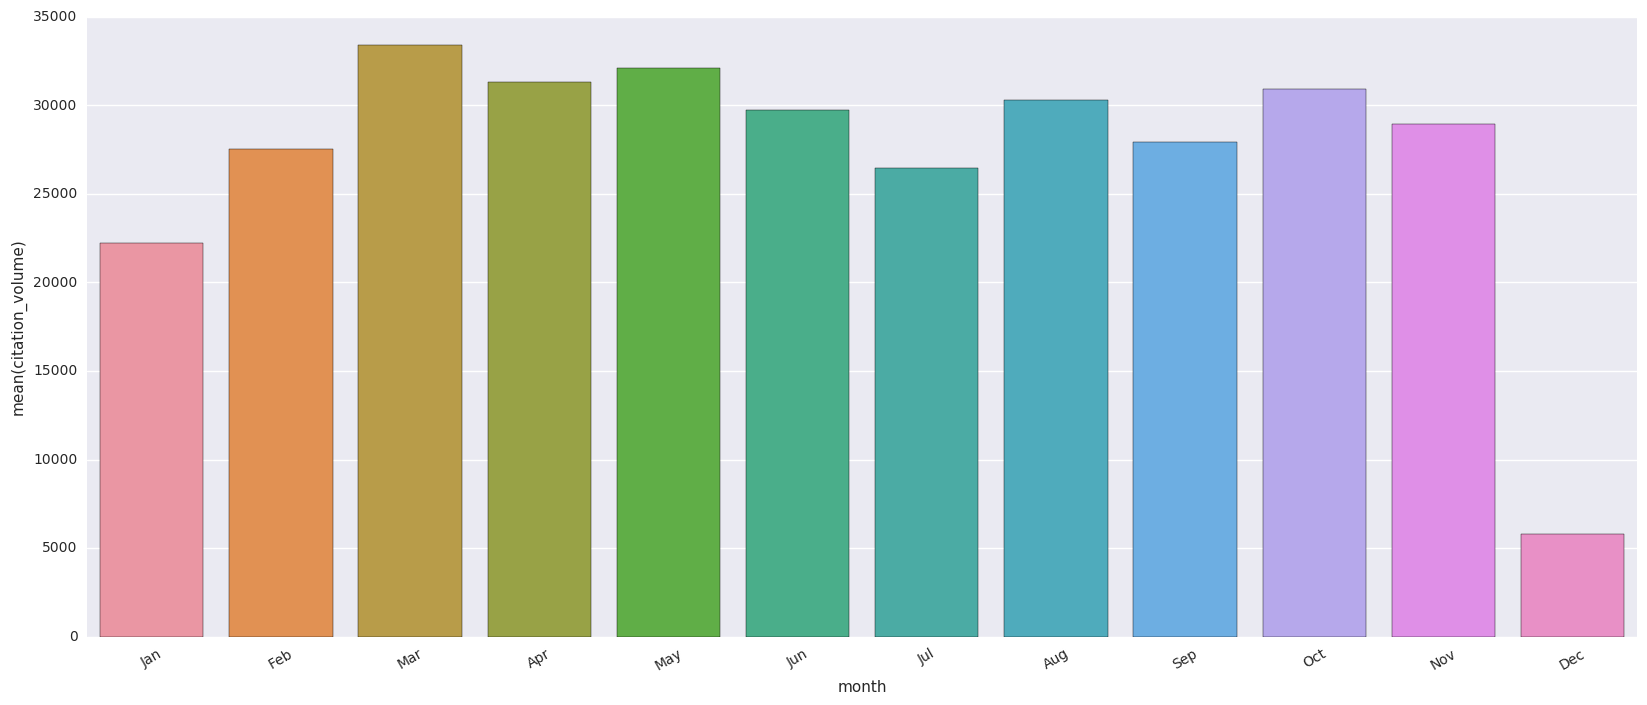

In [43]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='month', y='citation_volume', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=30)
del d

The above plot shows that traffic violations are highest around Spring and Fall, and decrease in the Winter and Summer. This phenomenon may be likely due to people taking vacation during the Summer months, and less people on the roads during the Winter. The low volume for December makes sense as this is 2016 data and we have only just entered the month, however the lower volume for January looks interesting and warrants follow-up.

Based on the above, we looked at daily traffic citation volume for the month of January to see if we could explain why it was lower than the other comparable months.

In [44]:
%%sql
Select date(violdate) as day
    , count(*) as citation_volume
From citation
Where date_part('month', violdate) = 1
Group By date(violdate) 
Order By 1;

31 rows affected.


day,citation_volume
2016-01-01,32
2016-01-02,567
2016-01-03,309
2016-01-04,1210
2016-01-05,1178
2016-01-06,1224
2016-01-07,1295
2016-01-08,1385
2016-01-09,822
2016-01-10,440


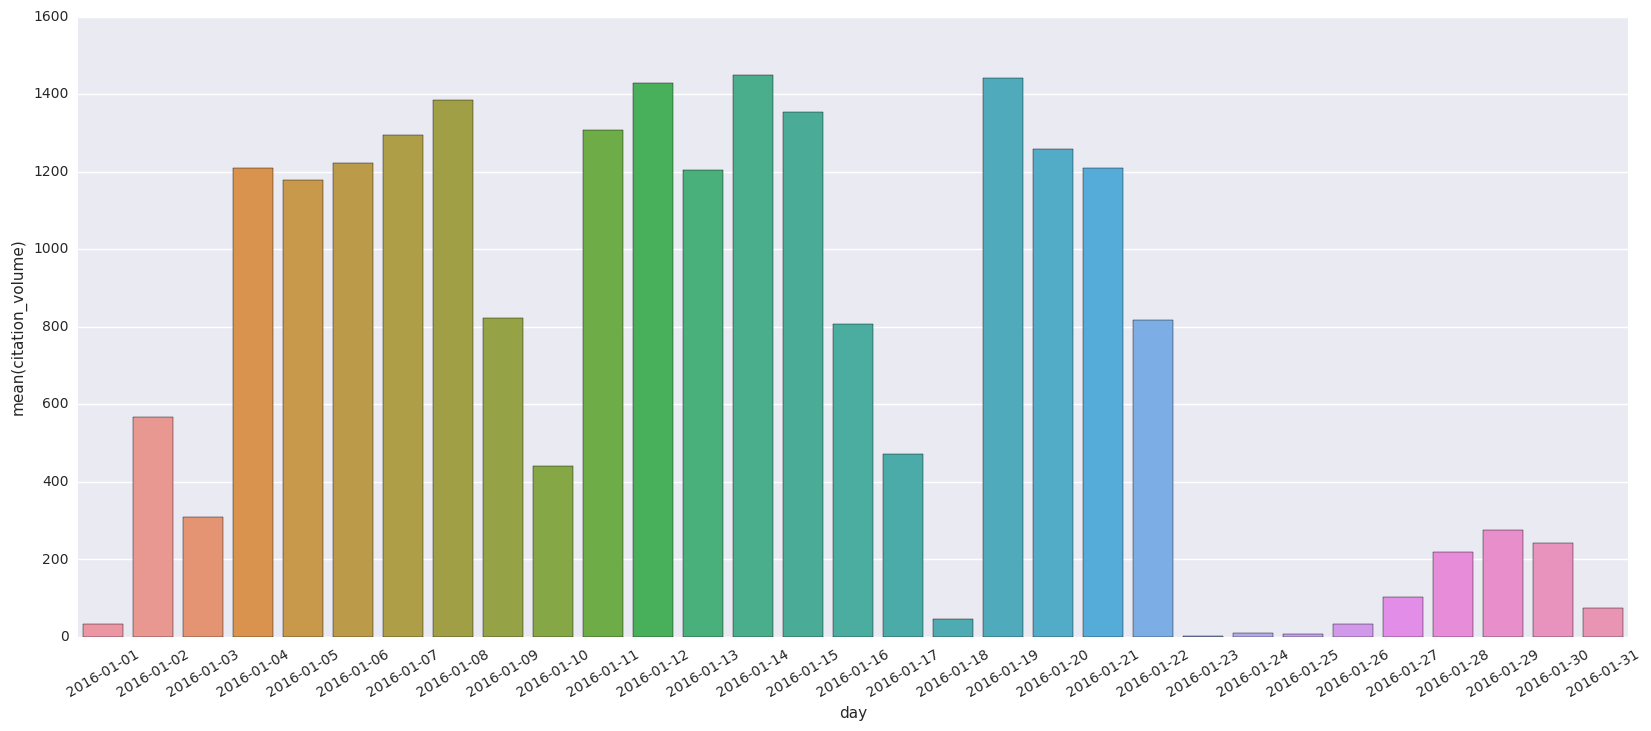

In [45]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='day', y='citation_volume', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=30)
del d

This analysis shows an anomalous decline of activity beginning 1/22/2016 and lasting for several days. Looking back at this time period, these days occurred during the blizzard which explains why very few parking tickets were issued. The other 2 days with very low activity: 1/1 and 1/17 were federal holidays, which also explains the pattern observed.

### Conclusions

Overall, we were able to identify many interesting qualities by analyzing the Baltimore Traffic Citation dataset. Some of these findings included:  
1. Neighborhoods near the inner harbor had a higher proportion of traffic citation volume on the weekends  
2. The most egregious traffic offender in Baltimore drives a Volkwswagen 
3. Thursdays at noon are the most susceptible time to receive a parking ticket  
Given more time, we would consider analyzing the entire dataset opposed to just 2016 so we could examine year over year trends. In addition, we would evaluate external sources for inclusion to see how they impact traffic citations. Weather data would be a good candidate as we saw from our January 2016 data that traffic citations and weather patterns had potential for correlation.

### Attestation

We attest that all group members contributed to this project. Specific contributions for group members included the following:  
* Jon: Identification of dataset, time series analyses, final write-up and drafting of markup  
* Amit: Evaluation of potential datasets, individual characteristics analysis  
* Wendy: Evaluation of potential datasets, violation code characteristics analysis  
* Wei: Data wrangling, cleansing, and loading; creation of D3 geospatial dashboard

### Appendix: Ipython Version of the D3 dashboard

##### Tips for embedding javascripts
    1. It seems javascript magic element.append accept one-line codes
    2. d3 can only work in HTML, javascript magic does not work.
    3. Take out comments in javascript codes
    4. The d3 codes are based on following online tutorials
*    http://feyderm.github.io/2016/03/14/baltimore_vacant_buildings_interactive_map.html
* https://bl.ocks.org/d3noob/bdf28027e0ce70bd132edc64f1dd7ea4
* https://bl.ocks.org/mbostock/3883245
* https://bl.ocks.org/shimizu/f90651541575f348a129444003a73467


Embedding D3 into jupyter notebook can be tricky. I can share with you about what I have learned so that you do not have go through the struggles i went through.
       
       
       

In [62]:
%%javascript
element.append("<style>.d3-tooltip {margin-top: 5px; width: 450px;height: 650px;position: absolute;z-index: 100;line-height: 1;font-weight: bold;padding: 5px;background: rgba(0, 0, 0, 0.8);color: #fff;text-align: left;border-radius: 10px;}.select{ margin-left: 50px;}</style>")
element.append("<div id='controls' style='margin-bottom:15px'></div>")
element.append(" <div id='summary' style='margin-bottom:15px'><label class='summary-label'>Neighborhood : </label><span id='nh-name'  style='margin-right:100px'></span><label class='summary-label'>Citation Count : </label><span id='citation-count' style='margin-right:100px'></span><label class='summary-label'>Total Fine : </label><span id='total-fine' style='margin-right:100px'></span></div>")
element.append("<div id='container'></div>");

<IPython.core.display.Javascript object>

In [63]:
### only way to bring d3 to jupyter notebook so far
from IPython.display import HTML
HTML("""
<script type="text/javascript">
require.config({paths: {d3: "http://d3js.org/d3.v4.min"}});
require(["d3"], function(d3) {
   var proj = d3.geoMercator().scale(180000)
                                .translate([290,300])
                                .center([-76.612223, 39.294504]);
    var path = d3.geoPath(proj);
    var zoom = d3.zoom()
        .scaleExtent([1, 10])
        .on("zoom", zoomed);
    var showStreets = false;
    var state = "All";
    var weekday = "All";
    var month = "All";
    var neighborhood ;
    var totalCount ;
    var streetData ;
    var citationData;
    var month_keys = d3.range(1,12);
    month_keys.unshift('All');
    var weekday_keys = ['All','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'];
    var summmarySvgWidth = 800;
    var summmarySvgHeight = 250;
    var margin = {top: 20, right: 20, bottom: 30, left: 40},
                width = summmarySvgWidth - margin.left - margin.right,
                height = summmarySvgHeight - margin.top - margin.bottom;
    function updateSummary(d) {
        d3.select('#nh-name').text(d.properties.csa);
        d3.select('#citation-count').text(d.properties.citation_count);
        d3.select('#total-fine').text("$" + d.properties.total_fine);
    }
    function zoomed() {
        d3.select('#map').attr("transform", d3.event.transform);
    }
    function createTooltip() {
        var tooltip = d3.select('#container')
            .append('div')
            .attr('id', 'tooltip')
            .attr('class', 'd3-tooltip')
            .style('visibility', 'hidden');
    }
    function showTooltip(d, cenLoc) {
        var tooltip = d3.select('#tooltip');
        tooltip.select('ul').remove();
        var ul = tooltip.append('ul').style("list-style", "none");
        for (var key in d) {
            if (d.hasOwnProperty(key)) {
                var li = ul.append("li").style('margin-top', '5px');
                li.append('label').text(key + ": ").style('margin-right', '15px'); 
                li.append('label').text(d[key]);
            }
        }               
         d3.select('#tooltip').style('top', (cenLoc[1]) + 'px')
                                    .style('left', (cenLoc[0]) + 'px')
                                    .style('visibility', 'visible');
    }
    function hideTooltip() {
       d3.select("#tooltip").style('visibility', 'hidden');
    }
    function createLegend(color, countMin, countMax) {
         var legendX1 = 650,
             legendWidth = 30,
             lengendY1 = 100,
             legendHeight = 200;
         var svg = d3.select('#headmapsvg');
         svg.append("g")
            .append("defs")
            .append("linearGradient")
            .attr("id","linearGradient")
            .attr("x1","0%")
            .attr("x2","0%")
            .attr("y2","0%")
            .attr("y1","100%"); 
        var stopvalGenerator = d3.interpolateNumber(countMin, countMax); 
        var stopColors = [];   
        for (var i = 0; i <=1.01; i +=0.01) {
            stopColors.push({perc: i, stopColorVal: stopvalGenerator(i)});
        }   
        console.log(stopColors.length);
        var stops = d3.select('#linearGradient')
                            .selectAll('stop')
                            .data(stopColors)
                            .enter()
                            .append('stop')
                            .attr('offset',function(d) {
                                    return d.perc;
                            })
                            .attr('stop-color', function(d) {
                                return color(d.stopColorVal);
                            });                 
        var legend = svg.append("g").attr("id", "legend");
            legend.append("rect")
                    .attr("fill","url(#linearGradient)")
                    .attr("x",legendX1)
                    .attr("y",lengendY1)
                    .attr("width",legendWidth)
                    .attr("height",legendHeight);
        var p = d3.precisionFixed(1);
        var intFormat = d3.format("." + p + "f");
        for (var i = 0; i<=100; i += 25 ){
            legend.append("text")
                .attr("class","legendText")
                .attr("class","legendText")
                .attr("text-anchor", "left")
                .attr("x",legendX1 + legendWidth + 15)
                .attr("y",lengendY1 + legendHeight * (100-i) / 100)
                .attr("dy",0)
                .text(intFormat(stopColors[i].stopColorVal));
        }
    }
    function stateStroke(d){
         if (d.State === state) {
                return "#cccc00";
            }  else{
                return "none";
            }
    }
    function stateStrokeWidth(d) {
      if (d.State === state) {
                return 0.5;
            }  else{
                return 0;
            }
    }
    function weekdayColor(d) {
         if (d.ViolWeekday === weekday) {
                return "#ff9900";
            }  else{
                return "#1a1a1a";
            }
    }
    function filterCitationByFine(){
        d3.selectAll('.point-shape').style('opacity', function(d){
            if (+d.ViolFine < fineFilterVal) {
                return 0;
            } else {
                return 0.35;
            }
        });
    }
    function updateMinFine(minFine){
        console.log(minFine);
        fineFilterVal = +minFine;
        d3.select("#min-fine-value").text('$' + minFine);
        d3.select("#min-fine").property("value", minFine);
        filterCitationByFine();
    }
    function createControls(data) {
        var stateSelect = d3.select('#controls').append('select')
                                                .attr('class', 'select')
                                                .on('change', function(){
                                                        var ind = d3.event.currentTarget.selectedIndex;
                                                        state = data.state_keys[d3.event.currentTarget.selectedIndex];
                                                        d3.selectAll('.point-shape')
                                                            .attr('stroke', stateStroke)
                                                            .attr('stroke-width', stateStrokeWidth);
                                                    });
          stateSelect.selectAll('option')
            .data(data.state_keys)
            .enter()
            .append('option')
            .attr('value', function(d){return d;})
            .text(function(d) {return d;});
        var monthSelect = d3.select('#controls').append('select')
                        .attr('class', 'select')
                        .on('change', function(){
                            var ind = d3.event.currentTarget.selectedIndex;
                            month = data.month_keys[d3.event.currentTarget.selectedIndex];
                            var points = d3.selectAll('.point');
                            d3.selectAll('.point-rect').remove();
                            d3.selectAll('.point-circle').style('opacity', 0.35);
                            console.log(points.data());
                            var curMonth = points.data()
                                                    .filter(function(d){
                                                        return month.toString() === d.ViolMonth; 
                                                    });
                            console.log(curMonth);
                            var curMonthPoints =  points.data(curMonth);
                            curMonthPoints.selectAll(".point-circle").style("opacity", 0);
                            curMonthPoints.append('rect')
                                          .attr('class','point-shape point-rect')
                                          .attr('x', function(d){
                                                console.log(d);
                                                 return proj([+d.Longitude, +d.Latitude])[0]-2;
                                          })
                                          .attr('y', function(d){
                                                 return proj([+d.Longitude, +d.Latitude])[1]-2;
                                          })
                                          .attr('width',5)
                                          .attr('height', 5)
                                          .attr('fill', weekdayColor)
                                          .style("opacity", 0.35)
                                          .attr('stroke', stateStroke)
                                          .attr('stroke-width', stateStrokeWidth);
                            console.log("change shape");          
                        });
        monthSelect.selectAll('option')
            .data(month_keys)
            .enter()
            .append('option')
            .attr('value', function(d){return d;})
            .text(function(d) {return d;});
        var weekdaySelect = d3.select('#controls').append('select')
                        .attr('class', 'select')
                        .on('change', function(){
                            var ind = d3.event.currentTarget.selectedIndex;
                            weekday = data.weekday_keys[d3.event.currentTarget.selectedIndex];
                            console.log(weekday);
                            d3.selectAll('.point-shape').attr('fill', weekdayColor);
                        });
           weekdaySelect.selectAll('option')
            .data(weekday_keys)
            .enter()
            .append('option')
            .attr('value', function(d){return d;})
            .text(function(d) {return d;});
        var showStreetBtn =  d3.select('#controls').append('button')
            .attr('class', 'select')
            .text('Toggle Streets')
            .on('click', function(){
                   showStreets  = !showStreets;
                   console.log(showStreets);
                  if (showStreets) {
                      if(streetData !== undefined) {
                          plotStreets(streetData);
                      } else {
                          d3.json('Street_Centerlines.geojson', plotStreets);
                      } 
                  } else {
                     d3.select('.streets').remove();
                  }
            });
    }
    d3.select('#controls').append('label').attr('class',"summary-label").text("Fine Over: ").append("span").attr("id", "min-fine-value");
    d3.select('#controls').append('input').attr('type', 'range')
                                          .attr('id', 'min-fine')
                                          .attr('min',0)
                                          .attr('max',1000)
                                          .attr('value',0)
                                          .style('width', '250px')
                                          .on('input', function(){
                                                     updateMinFine(+this.value);
                                                 });
    function createSummaryPlots() {
        console.log("creating summary plots");
      var plotDiv =d3.select('#container')
            .append('div')
            .attr('id', "summaryplots")
            .style('display', 'inline-block')
            .style('width','40%')
            .style('height', '100%');
     plotDiv.append("lengnd").text('State Count');
      var stateGroup = plotDiv.append('svg')
            .attr('id', 'stateSvg')
            .attr('width', summmarySvgWidth)
            .attr('height', summmarySvgHeight)
            .append("g")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
            .attr('id', 'stateGroup')
            .attr("transform", 
                "translate(" + margin.left + "," + margin.top + ")");
      stateGroup.append("g")
                    .attr('id', 'stateXaxis')
                    .attr("transform", "translate(0," + height + ")");
      stateGroup.append("g")
                    .attr('id', 'stateYaxis');
      plotDiv.append("lengnd").text('Month Count');
      var monthGroup = plotDiv.append('svg')
            .attr('id', 'monthSvg')
            .attr('width', summmarySvgWidth)
            .attr('height', summmarySvgHeight)
            .append("g")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
            .attr('id', 'monthGroup')
            .attr("transform", 
                "translate(" + margin.left + "," + margin.top + ")")
       monthGroup.append("g")
                    .attr('id', 'monthXaxis')
                    .attr("transform", "translate(0," + height + ")");
      monthGroup.append("g")
                    .attr('id', 'monthYaxis');  
      var weekdayGroup = plotDiv.append('svg')
            .attr('id', 'weekdaySvg')
            .attr('width', 500)
            .attr('height', 500)
            .append("g")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
            .attr('id', 'weekdayGroup')
            .attr("transform", "translate(" + 250 + "," + 250 +")"); // Moving the center point. 1/2 the width and 1/2 the height
    }
        function createStateSummaryPlot(data){
             var stateData = data.properties.state_count;
                var x = d3.scaleBand()
                        .range([0, width])
                        .domain(stateData.map(function(d) {
                            return d.State; }))
                        .padding(0.1);
                var ymax = d3.max(stateData, function(d){return d.value;});
                var y = d3.scaleLinear()
                        .domain([0, ymax])
                        .range([height, 0]);    
                var bars = d3.select('#stateGroup').selectAll(".bar")
                            .data(stateData, function(d){return d.State;});
                 bars.exit().transition()
                                .duration(300)
                                .attr("y", y(0))
                                .attr("height", height - y(0))
                                .style('fill-opacity', 1e-6).remove();  
                var enterBars =  bars.enter()
                            .append("rect")
                            .on("mouseover", function(d) {
                                console.log('hi');
                                d3.select(d3.event.currentTarget)
                                    .select(".bartext")
                                    .style('opacity', 1);
                            })
                            .on("mouseout", function(d, i) {
                                d3.select(d3.event.currentTarget).attr("fill", "steelblue");
                                d3.select(d3.event.currentTarget)
                                    .select(".bartext")
                                    .style('opacity', 0);
                                })
                                .attr("class", "bar")
                                .attr("y", y(0))
                                .attr("height", height - y(0))
                                .attr("fill", "steelblue")
                                ;  

                        enterBars.merge(bars)
                            .transition().duration(300)
                            .attr("x", function(d) { 
                                    return x(d.State); })
                            .attr("width", x.bandwidth())
                            .attr("y", function(d) { 
                                    return y(d.value); })
                            .attr("height", function(d) { return height - y(d.value); })
                           ;

                    d3.select('#stateXaxis').call(d3.axisBottom(x));
                    d3.select('#stateYaxis').call(d3.axisLeft(y));       

        }
    function createMonthSummaryPlot(data){
        monthData = data.properties.month_count;
        var x = d3.scaleLinear().range([0, width]).domain([0, 11]);
        var ymax = d3.max(monthData, function(d){return d.value;});
        var y = d3.scaleLinear().range([height, 0]).domain([0, ymax]);
        var countline = d3.line()
            .x(function(d) { 
                return x(+d.ViolMonth); })
            .y(function(d) { return y(d.value); });
        d3.select('#monthGroup').selectAll('path').remove();
        var line = d3.select('#monthGroup').append('path')
                  .data([monthData]) // data have to take array of lines 
                  .attr('class', 'line') //line attribute for path
                    .attr("d", countline)
                    .attr("fill", 'none')
                    .attr("stroke", "steelblue")
                    .attr("stroke-width", 2)
                    ;
         d3.select('#monthXaxis').call(d3.axisBottom(x));
         d3.select('#monthYaxis').call(d3.axisLeft(y));       
    }
    function createWeekdayhSummaryPlot(data){
        var weekData = data.properties.weekday_count;
        console.log(weekData);
        var colors = d3.scaleOrdinal(d3.schemeCategory10);
        var radius = 240;
        var arc = d3.arc()
            .outerRadius(radius - 10)
            .innerRadius(0);
        var labelArc = d3.arc()
            .outerRadius(radius - 40)
            .innerRadius(radius - 40);
        var pie = d3.pie()
            .value(function(d) { return d.value; })(weekData);
        d3.select('#weekdayGroup').selectAll("arc")
                            .remove().transition()
                            .duration(300);
        var g = d3.select('#weekdayGroup').selectAll("arc")
                .data(pie)
                .enter().append("g")
                .attr("class", "arc");
        g.append("path")
          .attr("d", arc)
          .attr("fill", function(d) { 
              console.log(d.data.ViolWeekday);
              console.log(colors(d.data.ViolWeekday));
              return colors(d.data.ViolWeekday); 
            })
          .attr("stroke", "#fff")
          .attr("stroke-width", 2)
          .transition()
          .duration(300);
        d3.selectAll('.arctext').remove();
        g.append("text")
            .attr('class', 'arctext')
            .attr("transform", function(d) { return "translate(" + labelArc.centroid(d) + ")"; })
                .text(function(d) { return d.data.ViolWeekday;})	
                .style("fill", "gray");
    }
    function plotStreets(data) {
        streetData = data;
        var streetG = d3.select('#map').append('g').attr('class', 'streets');
        var gs = streetG.selectAll('g')
                    .data(data.features)
                    .enter()
                    .append('g')
                    .append('path')
                    .attr('d', path)
                    .attr('opacity', 0.3)
                    .attr('stroke', 'blue')
                    .attr('stroke-width', 1)
                    .attr('class', 'neighborhood')
                    .attr('fill', 'none')
                    ;
    }
    function plotCitation(d, shape) {
      shape.selectAll('g')
            .data(d.properties.data_points, function(d) { return d.Citation;})
            .enter()
            .append('g')
            .attr('class', 'point')
            .append('circle') 
            .attr('class', 'point-shape point-circle')
            .on('mouseover', function(d) {
                        var cenLoc = proj([+d.Longitude, +d.Latitude]);
                        showTooltip(d, cenLoc); 
              })
            .on('mouseout', function(d){
                hideTooltip();
            })
            .transition()
            .duration(500)
            .attr('cx', function(d) {
                return proj([+d.Longitude, +d.Latitude])[0];
            })
            .attr('cy', function(d) {
                return proj([+d.Longitude, +d.Latitude])[1];
            })
            .attr('r', 2)
            .attr('fill', '#1a1a1a')
            .style("opacity", 0.35)
            ;
    }
    function plotArea(data){
        citationData = data;
        var svg = d3.select('#container')
                .style('width','1200px')
                .style('height', '1500px')
                .append('div')
                .attr('id', "heatmap")
                .style('display', 'inline-block')
                .style('vertical-align','top')
                .style('width','60%')
                .style('height', '100%')
                .append('svg')
                .attr('id', 'headmapsvg')
                .attr('width', 800)
                .attr('height', 800);
        var map = svg.append('g').attr('id', 'map').call(zoom);       
        var citationCounts = [];
        for (var i=0; i < data.features.length; i++) {
            citationCounts.push(data.features[i].properties.citation_count);
        }
        var countMin = d3.min(citationCounts);
        var countMean = d3.mean(citationCounts);
        var countMax = d3.max(citationCounts);

        var colorDomain = [countMin,
                      countMean,
                      countMax];
        var color = d3.scaleLinear()
                .domain(colorDomain)
                .range(["#ffffbf", "#2c7bb6", "#d7191c"])
                .interpolate(d3.interpolateHcl);
        var areaG = map.append('g').attr('class', 'areaGroup');
        var gs = areaG.selectAll('g')
                    .data(data.features, function(d){return d.properties.csa;});
        gs.exit().remove();
        var areas = gs.enter()
                    .append('g')
                    .append('path')
                    .attr('d', path)
                    .attr('opacity', 0.6)
                    .attr('stroke', 'gray')
                    .attr('stroke-width', 1)
                    .attr('class', 'neighborhood')
                    .attr('fill', function(d ){
                        return color(d.properties.citation_count);
                    })
                    .on('click', function(d) {
                            d3.event.stopPropagation();
                            var curPath = d3.select(d3.event.currentTarget);
                            curPath.attr('opacity', 1);
                            if (curPath.attr('data-show') === undefined || curPath.attr('data-show') === 'false' ) {
                                var shape = d3.select(this.parentNode);
                                plotCitation(d,shape);
                                curPath.attr('data-show' ,'true');
                            } else {
                                curPath.attr('data-show' ,'false');
                                var g = d3.select(this.parentNode);
                                g.selectAll('.point').remove();
                            }
                            updateSummary(d);
                            createStateSummaryPlot(d);
                            createMonthSummaryPlot(d);
                            createWeekdayhSummaryPlot(d);

                    })
                  .on('mouseover', function(d) {
                      d3.event.stopPropagation();
                      d3.select(this).style("cursor", "pointer");
                  })
                  .on('mouseout', function (d) {
                        d3.select(this).style("cursor", "default");
                 });
        areas = areas.merge(gs);  
        createLegend(color, countMin, countMax);
        createTooltip();
        createControls(data);
        console.log('creating');
        createSummaryPlots();
    }
    d3.json('citation.geojson', plotArea);
});
</script>
""")